### Memory occupation in array

In [8]:
import json
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [9]:
def analyze_memory_occupation(json_file_path):
    """
    Analyze memory occupation of COMP_OP operations from JSON file

    Args:
        json_file_path (str): Path to the JSON file

    Returns:
        dict: Analysis results with arrays and statistics
    """

    # Read JSON file
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    # Extract COMP_OP entries
    comp_ops = []

    for item in data['workload']:
        if item.get('type') == 'COMP_OP':
            comp_ops.append({
                'id': item['id'],
                'size': item['size'],
                'node': item['node'],
                'layer_id': item.get('layer_id', 0),
                'weight_size': item.get('weight_size', 0),
                'comp_time': item.get('ct_required', 0),
                'dependencies': item.get('dep', [])
            })

    # Create numpy arrays for easier manipulation
    ids = np.array([op['id'] for op in comp_ops])
    sizes = np.array([op['size'] for op in comp_ops])
    nodes = np.array([op['node'] for op in comp_ops])
    layers = np.array([op['layer_id'] for op in comp_ops])
    weights = np.array([op['weight_size'] for op in comp_ops])
    comp = np.array([op['comp_time'] for op in comp_ops])
    deps = np.array([op['dependencies'] for op in comp_ops], dtype=object)

    # Create DataFrame for easier analysis
    df = pd.DataFrame({
        'id': ids,
        'size': sizes,
        'node': nodes,
        'layer_id': layers,
        'weight_size': weights,
        'comp_time': comp,
        'dependencies': deps
    })

    # Group by node for memory analysis
    node_memory = defaultdict(lambda: {'total_size': 0, 'total_weight': 0, 'computing_time': 0, 'n_deps': 0, 'operations': [], 'layer_ids': set()})

    for op in comp_ops:
        node_memory[op['node']]['total_size'] += op['size']
        node_memory[op['node']]['total_weight'] += op['weight_size']
        node_memory[op['node']]['computing_time'] += op['comp_time']
        node_memory[op['node']]['n_deps'] += len(op['dependencies'])
        node_memory[op['node']]['operations'].append(op['id'])

    # Print analysis results
    print("="*60)
    print("COMP_OP MEMORY OCCUPATION ANALYSIS")
    print("="*60)

    print(f"\nTotal COMP_OP operations found: {len(comp_ops)}")
    print(f"Total memory usage: {np.sum(sizes)}")
    print(f"Total weight usage: {np.sum(weights)}")
    print(f"Total computation time: {np.sum(comp)}")
    print(f"Total dependencies: {sum(len(dep) for dep in deps)}")
    print(f"Unique nodes: {len(np.unique(nodes))}")

    print("\nMemory Occupation by Node:")
    print("-"*50)
    print("Node\tTotal Size\tTotal Weight\tTotal CompTime\tTotal Deps\tOp Count\tOperation IDs")
    for node in sorted(node_memory.keys()):
        mem = node_memory[node]
        ops_str = ', '.join(map(str, mem['operations']))
        print(f"{node}\t{mem['total_size']}\t{mem['total_weight']}\t{mem['computing_time']}\t{mem['n_deps']}\t{len(mem['operations'])}\t[{ops_str}]")

    # Statistics
    print("\nStatistics:")
    print("-"*30)
    print(f"Average operation size: {np.mean(sizes):.2f}")
    print(f"Max operation size: {np.max(sizes)}")
    print(f"Min operation size: {np.min(sizes)}")
    print(f"Standard deviation: {np.std(sizes):.2f}")
    print(f"Average computation time: {np.mean(comp):.2f}")
    print(f"Max computation time: {np.max(comp)}")
    print(f"Min computation time: {np.min(comp)}")
    print(f"Standard deviation (comp time): {np.std(comp):.2f}")
    print(f"Average dependencies per op: {np.mean([len(dep) for dep in deps]):.2f}")
    print(f"Max dependencies per op: {max([len(dep) for dep in deps]) if len(deps) > 0 else 0}")
    print(f"Min dependencies per op: {min([len(dep) for dep in deps]) if len(deps) > 0 else 0}")

    # Node load balance analysis
    node_loads = [node_memory[node]['total_size'] for node in node_memory.keys()]
    print(f"\nNode Load Balance:")
    print(f"Most loaded node: {max(node_loads)} units")
    print(f"Least loaded node: {min(node_loads)} units")
    print(f"Load imbalance ratio: {max(node_loads)/min(node_loads):.2f}")

    # Return structured data
    return {
        'arrays': {
            'ids': ids,
            'sizes': sizes,
            'nodes': nodes,
            'layers': layers,
            'weights': weights,
            'comp': comp,
            'deps': deps
        },
        'dataframe': df,
        'node_memory': dict(node_memory),
        'statistics': {
            'total_operations': len(comp_ops),
            'total_size': np.sum(sizes),
            'total_weight': np.sum(weights),
            'total_comp_time': np.sum(comp),
            'total_deps': sum(len(dep) for dep in deps),
            'avg_size': np.mean(sizes),
            'max_size': np.max(sizes),
            'min_size': np.min(sizes),
            'std_size': np.std(sizes),
            'avg_comp_time': np.mean(comp),
            'max_comp_time': np.max(comp),
            'min_comp_time': np.min(comp),
            'std_comp_time': np.std(comp),
            'avg_deps': np.mean([len(dep) for dep in deps]),
            'max_deps': max([len(dep) for dep in deps]) if len(deps) > 0 else 0,
            'min_deps': min([len(dep) for dep in deps]) if len(deps) > 0 else 0,
            'unique_nodes': len(np.unique(nodes))
        }
    }

In [10]:
def plot_memory_distribution(results):
    """
    Plot memory distribution across nodes
    """    
    node_memory = results['node_memory']
    nodes = list(node_memory.keys())
    sizes = [node_memory[node]['total_size'] for node in nodes]
    
    plt.figure(figsize=(10, 6))
    plt.bar(nodes, sizes, color='skyblue', alpha=0.7)
    plt.xlabel('Node')
    plt.ylabel('Total Memory Size')
    plt.title('Memory Distribution Across Nodes')
    plt.grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(sizes):
        plt.text(nodes[i], v + max(sizes)*0.01, str(v), ha='center')
    
    plt.tight_layout()
    plt.show()

In [11]:
def plot_node_distribution_2d(results, metric_name, percentage = False, k=4, n=2, unit=None):
    """
    Plot node metric distribution as a 2D grid using imshow
    Node 0 is positioned at bottom-left corner
    
    Args:
        results: Results dictionary with 'node_memory' containing node data
        metric_name: Name of the metric to plot (e.g., 'total_size', 'total_weight', 'total_operations')
        k: Grid dimension (k x k grid, default 4 for 4x4 = 16 nodes)
        n: Number of dimensions (default 2 for 2D torus)
        unit: Memory unit for size/weight metrics ('B', 'KB', 'MB'), None for count metrics
    """
    
    # Metrics that represent memory/data sizes (need unit conversion)
    memory_metrics = {'total_size', 'total_weight'}
    
    # Create grid
    grid_size = k
    metric_grid = np.zeros((grid_size, grid_size))
    node_data = results['node_memory']  # Keep original key name for compatibility
    
    # Fill grid with metric values
    for node_id, data in node_data.items():
        row = node_id // grid_size
        col = node_id % grid_size
        metric_grid[row, col] = data[metric_name]
            
    # Create figure and axis with adjusted size to accommodate colorbar
    fig, ax = plt.subplots(figsize=(8, 8))  # Increased width to accommodate colorbar

    # Determine if we need unit conversion
    is_memory_metric = metric_name in memory_metrics and unit is not None

    if is_memory_metric:
        display_grid = convert_memory(metric_grid, unit)
        im = ax.imshow(display_grid, cmap='plasma', origin='lower', 
                    interpolation='nearest', aspect='equal')

        # Method 1: Using make_axes_locatable with better spacing
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.3)  # Increased pad
        cbar = fig.colorbar(im, cax=cax)
        cbar.set_label(f'{metric_name.replace("_", " ").title()} ({unit})', 
                    rotation=270, labelpad=20)

    elif percentage:
        total_value = np.sum(metric_grid)
        percentage_grid = convert_to_percentage(metric_grid, total_value)
        im = ax.imshow(percentage_grid, cmap='plasma', origin='lower', 
                    interpolation='nearest', aspect='equal')

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.3)
        cbar = fig.colorbar(im, cax=cax)
        cbar.set_label(f'{metric_name.replace("_", " ").title()} (%)', 
                    rotation=270, labelpad=20)

    else:
        im = ax.imshow(metric_grid, cmap='plasma', origin='lower', 
                    interpolation='nearest', aspect='equal')

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.3)
        cbar = fig.colorbar(im, cax=cax)
        cbar.set_label(f'{metric_name.replace("_", " ").title()}', 
                    rotation=270, labelpad=20)
    
    # Set ticks and labels
    ax.set_xticks(range(grid_size))
    ax.set_yticks(range(grid_size))
    ax.set_title(f'{metric_name.replace("_", " ").title()} Distribution')
    
    # Add text annotations
    max_val = np.max(metric_grid)
    for i in range(grid_size):
        for j in range(grid_size):
            metric_val = metric_grid[i, j]
            total_value = np.sum(metric_grid)
            
            # Format display value
            if is_memory_metric:
                display_val = convert_memory(metric_val, unit)
                if unit == 'B':
                    display_text = f'{int(display_val)}'
                elif unit == 'KB':
                    display_text = f'{display_val:.1f}'
                else:  # MB
                    display_text = f'{display_val:.2f}'
            elif percentage:
                display_val = convert_to_percentage(metric_val, total_value)
                display_text = f'{display_val:.1f}%'
            else:
                display_text = f'{int(metric_val)}'
            
            # Smart text color based on value intensity
            normalized_val = metric_val / max_val if max_val > 0 else 0
            text_color = 'white' if normalized_val < 0.8 else 'black'
            
            ax.text(j, i, display_text, 
                    ha='center', va='center', color=text_color, 
                    fontsize=12, fontweight='bold')
    
    # Use tight_layout with padding to ensure colorbar fits
    plt.tight_layout(pad=2.0)
    plt.show()
    
    # Print summary
    print(f"\n{metric_name.replace('_', ' ').title()} Summary:")
    print(f"Total: {np.sum(metric_grid):.2f}")
    print(f"Average: {np.mean(metric_grid):.2f}")
    print(f"Max: {np.max(metric_grid):.2f}")
    print(f"Min: {np.min(metric_grid):.2f}")


def convert_memory(value, unit):
    """Convert memory values to specified unit"""
    if unit == 'KB':
        return value / 1024
    elif unit == 'MB':
        return value / (1024 * 1024)
    else:  # 'B' or any other unit
        return value
    
def convert_to_percentage(value, total):
    """Convert value to percentage of total"""
    if total == 0:
        return 0
    return (value / total) * 100

COMP_OP MEMORY OCCUPATION ANALYSIS

Total COMP_OP operations found: 388
Total memory usage: 132732
Total weight usage: 50658
Total computation time: 565986
Total dependencies: 5045
Unique nodes: 16

Memory Occupation by Node:
--------------------------------------------------
Node	Total Size	Total Weight	Total CompTime	Total Deps	Op Count	Operation IDs
0	7139	2918	18779	325	24	[0, 24, 46, 73, 77, 105, 108, 109, 135, 140, 182, 196, 202, 206, 281, 283, 290, 299, 320, 336, 350, 358, 372, 380]
1	8973	3541	46819	308	24	[7, 14, 22, 35, 61, 62, 63, 110, 115, 143, 172, 177, 181, 212, 230, 238, 256, 286, 310, 323, 340, 363, 373, 384]
2	8095	2640	35909	327	24	[1, 34, 54, 55, 56, 118, 127, 128, 147, 164, 167, 205, 214, 224, 229, 245, 252, 294, 306, 332, 349, 353, 361, 379]
3	8054	3425	48568	333	22	[4, 39, 47, 79, 106, 111, 112, 124, 151, 190, 204, 209, 219, 234, 271, 298, 311, 329, 335, 355, 365, 387]
4	7702	2826	34634	333	24	[15, 23, 37, 72, 103, 138, 139, 142, 144, 150, 169, 199, 201, 207, 220,

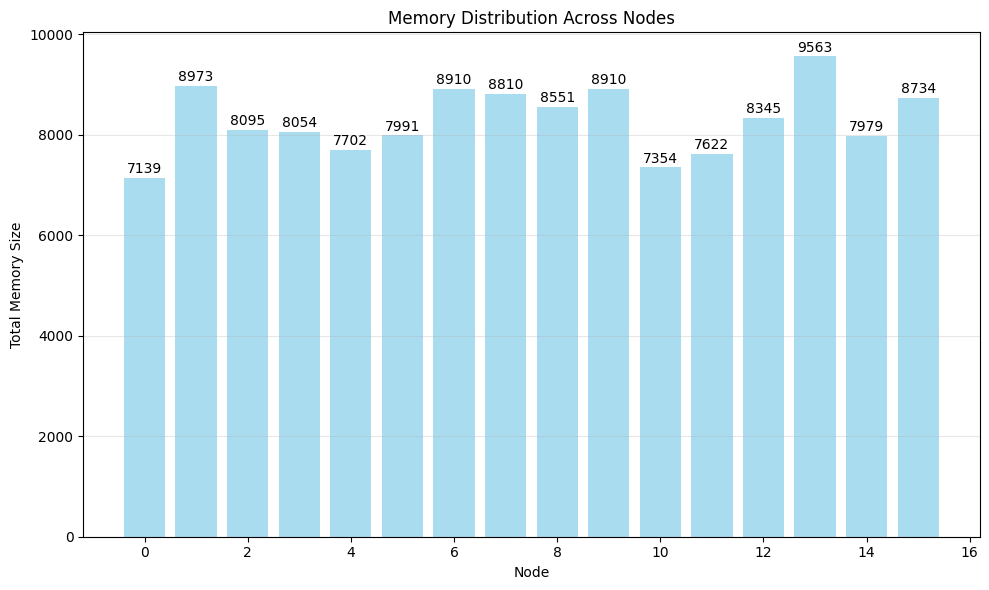

In [12]:
# Replace 'your_file.json' with your actual file path
json_file = '../data/ACO_LeNet4_test_lem_5k_run_2025-07-13_10-22-34/best_solution.json'  # or 'your_file.json'
verbose = False
try:
    results = analyze_memory_occupation(json_file)
    
    if verbose:
        # Access the arrays
        print("\n" + "="*60)
        print("ACCESSING THE DATA ARRAYS:")
        print("="*60)
        print("IDs array:", results['arrays']['ids'])
        print("Sizes array:", results['arrays']['sizes'])
        print("Nodes array:", results['arrays']['nodes'])
        print("Layers array:", results['arrays']['layers'])
        print("Weights array:", results['arrays']['weights'])
        print("Computation times array:", results['arrays']['comp'])
        print("Dependencies array:", results['arrays']['deps'])
        
    
    # Optional: Create visualization
    plot_memory_distribution(results)
    
except FileNotFoundError:
    print(f"Error: File '{json_file}' not found.")
    print("Please update the file path in the script.")
except json.JSONDecodeError:
    print("Error: Invalid JSON format in the file.")
except Exception as e:
    print(f"Error: {e}")

In [13]:
# plot_node_distribution_2d(results, 'total_size', unit='KB')      # For memory metrics
# plot_node_distribution_2d(results, 'total_operations')  #operations missing yet        # For count metrics
# plot_node_distribution_2d(results, 'total_weight', unit='KB')   # For weight metrics
# plot_node_distribution_2d(results, 'computing_time')           # For time metrics
# plot_node_distribution_2d(results, 'n_deps')                # For dependency count

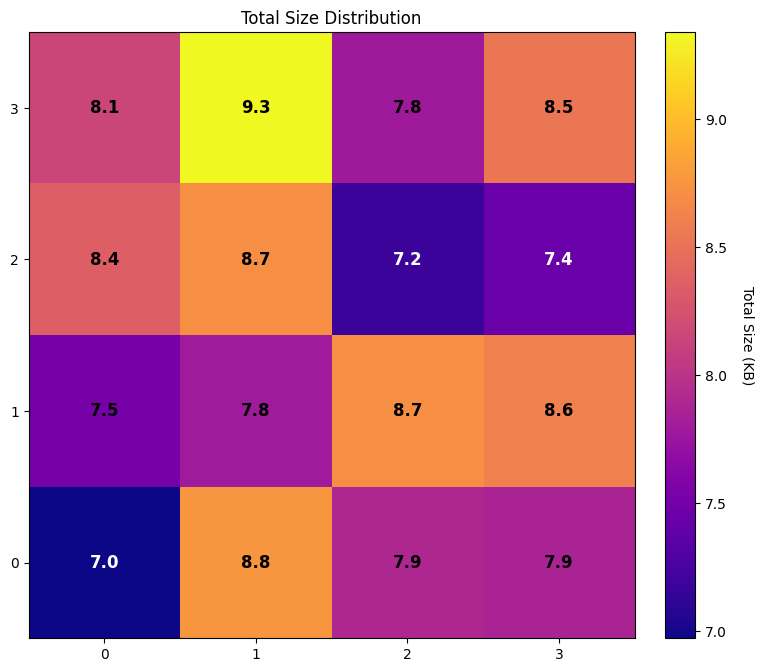


Total Size Summary:
Total: 132732.00
Average: 8295.75
Max: 9563.00
Min: 7139.00


In [14]:
plot_node_distribution_2d(results, 'total_size', percentage=False, unit='KB')      # For memory metrics

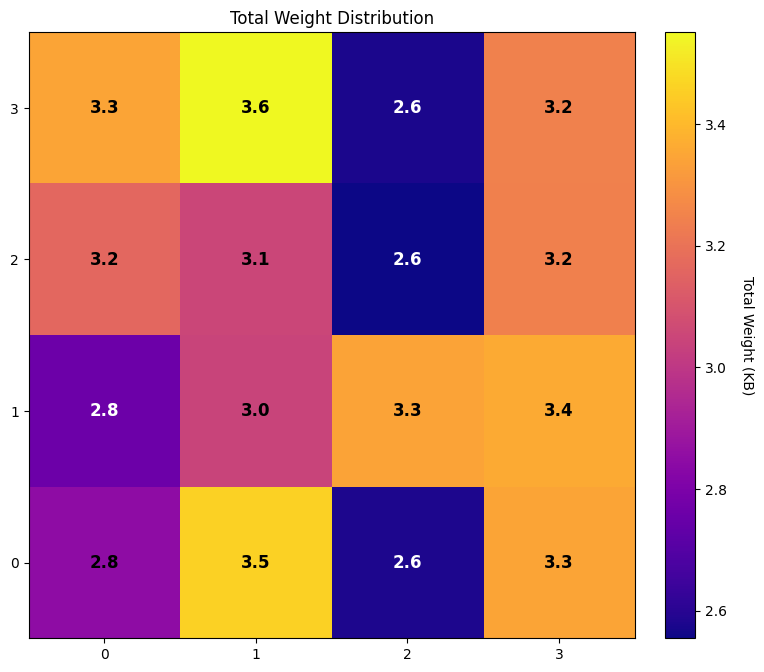


Total Weight Summary:
Total: 50658.00
Average: 3166.12
Max: 3636.00
Min: 2616.00


In [15]:
plot_node_distribution_2d(results, 'total_weight', unit='KB')

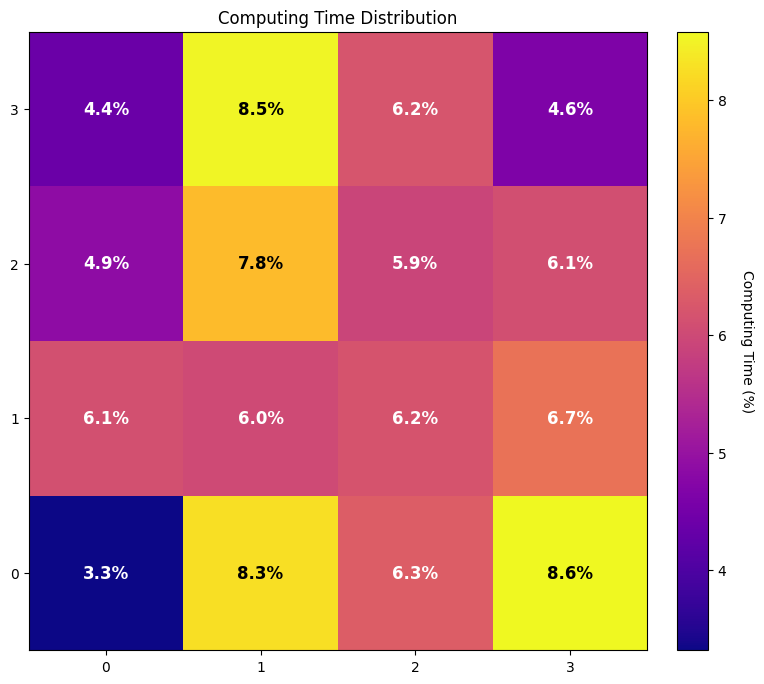


Computing Time Summary:
Total: 565986.00
Average: 35374.12
Max: 48568.00
Min: 18779.00


In [16]:
plot_node_distribution_2d(results, 'computing_time', percentage=True)

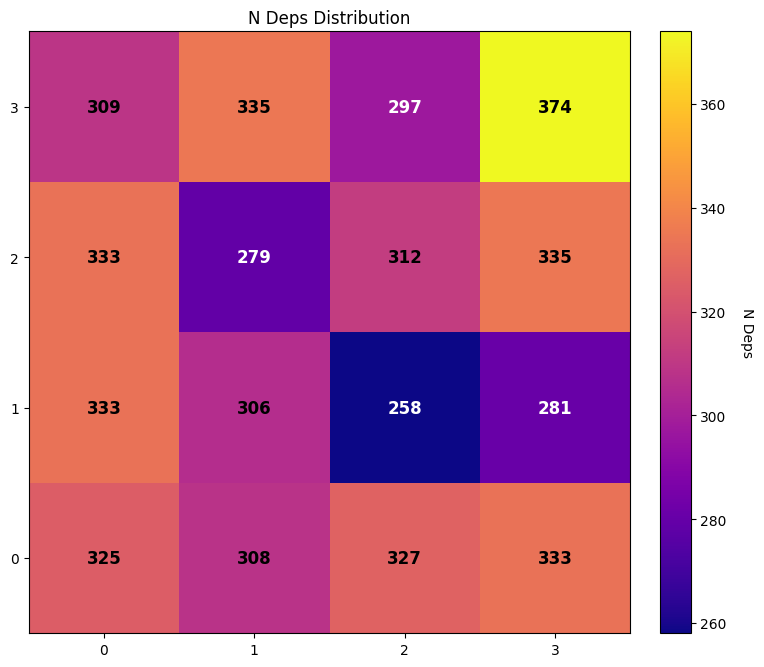


N Deps Summary:
Total: 5045.00
Average: 315.31
Max: 374.00
Min: 258.00


In [17]:
plot_node_distribution_2d(results, 'n_deps') 

### Add also above way to print which network is where mapped!